# <font color='red'> KNN Homework: </font>

## Import Libraries

In [304]:
# import the required packages 
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
import xlrd

## Import Training Data

In [305]:
lendfile = pd.read_excel('C:/Users/EP Analyzer/Downloads/ProgrammingTraining/Lantern-master/Mar20-KNN/data/Loan_Lending.xlsx', sheetname='model-build', header=0)

# <font color='red'> Basic Classification: </font>

## Get Features And Labels, Split Data Into Train-Test Sets,  Scale Features And Fit KNN Classifier

In [306]:
features = lendfile.iloc[:,0:-1]
labels = lendfile.iloc[:,-1]

In [312]:
features_train,features_test,labels_train,labels_test = train_test_split(features,labels,test_size=0.3)

In [315]:
# Standardize the data before modeling  
sc = StandardScaler()
sc.fit(features_train)
features_train_std = sc.transform(features_train)
features_test_std = sc.transform(features_test)

In [316]:
knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(features_train_std, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Use Fitted KNN Classifier On Validation Data

In [317]:
labels_pred = knn.predict(features_test_std)
print('Accuracy: %.2f' % accuracy_score(labels_test, labels_pred))
print('Misclassified samples: %d' % (labels_test != labels_pred).sum())

Accuracy: 0.97
Misclassified samples: 17


# <font color='red'> Finding Optimal Parameters </font>

## Loop Over Number Of Dimension Of The Feature Set And Within Each Loop, Perform A Grid Search Over A Range Of Parameters (Number Of Neighbours - 0 To 25, P - 1,2,3) With A 5-Fold Cross Validation To get Best Accuracy Score Each Number Of Dimensions

## N.B.: Since The Features Are Principal Components, It Would Be Fair To Assume That They Are Arranged In Decreasing Order Of Variance Information And Hence, Choosing The N Dimensions In Order Is OK

In [318]:
params = []
for n in range(1,features_test_std.shape[1]+1):
    print(n)    
    truncated_features = features_train_std[:,0:n]         
    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    param_grid = { 
        'n_neighbors': np.arange(1,25),
        'p': [1,2,3],
        'metric' : ['minkowski']
    }

    CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
    CV_knn.fit(truncated_features, labels_train)
    params.append([CV_knn.best_params_['n_neighbors'],CV_knn.best_params_['p'], CV_knn.best_score_])  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


## Make A DataFrame Of The Parameter List With Accuracies

In [319]:
nn = pd.DataFrame(params)
nn.columns=['#Neighbours','P','Accuracy']
nn['#Dimensions'] = nn.index+1
nn

,#Neighbours,P,Accuracy,#Dimensions
0,22,1,0.848812,1
1,6,3,0.902088,2
2,4,2,0.914327,3
3,4,1,0.949604,4
4,2,2,0.956084,5
5,3,3,0.953204,6
6,2,1,0.956084,7
7,1,1,0.955364,8
8,5,1,0.957523,9
9,5,1,0.961843,10


## Plot The Accuracies Versus Number Of Dimensions With A Colour Coding For The Number Of Neighbours

In [320]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

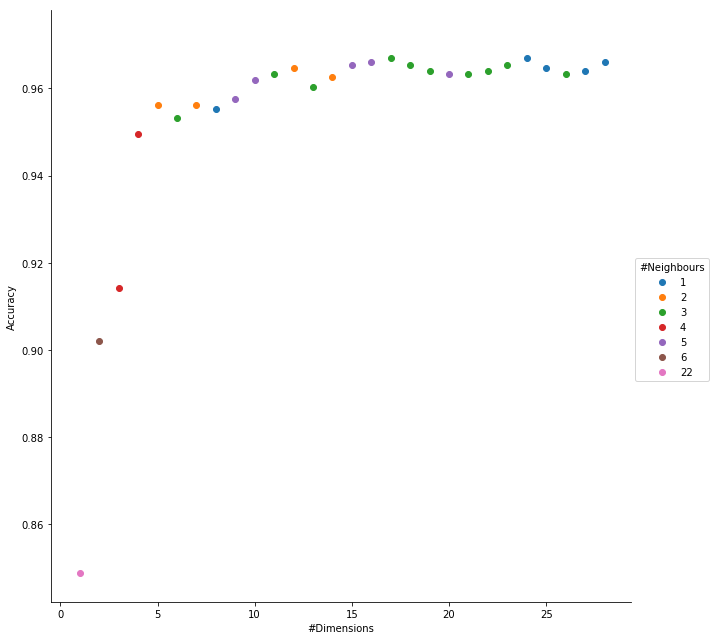

In [321]:
#KS = {'color': ['blue', 'red', 'green']}
sb.FacetGrid(nn, hue="#Neighbours",size=9).map(plt.scatter,"#Dimensions","Accuracy").add_legend()

## Find The Parameters Corresponding To The Best Accuracy And Fit A KNN Classifier With Them After Truncating The Training Dataset Accordingly

In [328]:
nn = pd.DataFrame(params)
numberofdimensions = int(nn[nn[2]==nn[2].max()].index[0])
numberofneighbours = int(nn.iloc[numberofdimensions][0])
numberofp = int(nn.iloc[numberofdimensions][1])
numberofdimensions

16

In [329]:
knn = KNeighborsClassifier(n_neighbors=numberofneighbours, p=numberofp, metric='minkowski')
truncated_features = features_train_std[:,0:numberofdimensions]         
knn.fit(truncated_features, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='uniform')

## Truncate Features Of The Test Dataset Accordingly

In [330]:
truncated_features_ = features_test_std[:,0:numberofdimensions]        

labels_pred = knn.predict(truncated_features_)
print('Accuracy: %.2f' % accuracy_score(labels_test, labels_pred))
print('Misclassified samples: %d' % (labels_test != labels_pred).sum())

Accuracy: 0.96
Misclassified samples: 21


## Import The Unclassified Dataset

In [342]:
lendtest = pd.read_excel('C:/Users/EP Analyzer/Downloads/ProgrammingTraining/Lantern-master/Mar20-KNN/data/Loan_Lending.xlsx', sheetname='evaluation', header=0)

## Scale And Truncate The Unclassified Dataset Features

In [345]:
featuresevaluate = lendtest.iloc[:,0:-1]
features_evaluate_std = sc.transform(featuresevaluate)
truncated_features_evaluate = features_evaluate_std[:,0:numberofdimensions]        

## Classify The Samples In The Unclassified Dataset Using The KNN Classifier

In [346]:
labels_pred_evaluate = knn.predict(truncated_features_evaluate)
labels_pred_evaluate

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int64)

## Update The Label Column Of The Unclassified Dataset DataFrame With The Classification And Export DataFrame To CSV File

In [347]:
lendtest['Class']=labels_pred_evaluate
lendtest

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,3.490065,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,0
1,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,-0.153997,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0
2,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,0
3,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,...,0.006666,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0
4,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.348176,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0
5,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,0
6,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,0
7,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
8,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
9,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


In [348]:
lendtest.to_csv('C:/Users/EP Analyzer/Downloads/ProgrammingTraining/Lantern-master/Mar20-KNN/data/KNNLendEvaluation.csv')